In [1]:
import numpy as np
from matplotlib import pyplot as plt
import jax.numpy as jnp
from jax import jit, grad, jacfwd, jacrev

# Define Dynamics Function

In [2]:
def pendulum_dynamics_wo_control(x):

    g = 9.81
    l = 1
    
    q    = x[0]
    q_d  = x[1]
    q_dd = -g/l * np.sin(q)

    return np.array([q_d, q_dd])

## Method 1. Forward Euler Integration

In [3]:
def pendulum_forward_euler(dynamics_func, x0, Tf, h):
    
    t = np.arange(0, Tf, h)

    x_hist = np.zeros((len(t), len(x0)))
    x_hist[0] = x0

    for i in range(1, len(t)):
        x_hist[i] = x_hist[i-1] + h * dynamics_func(x_hist[i-1])
    
    return x_hist, t

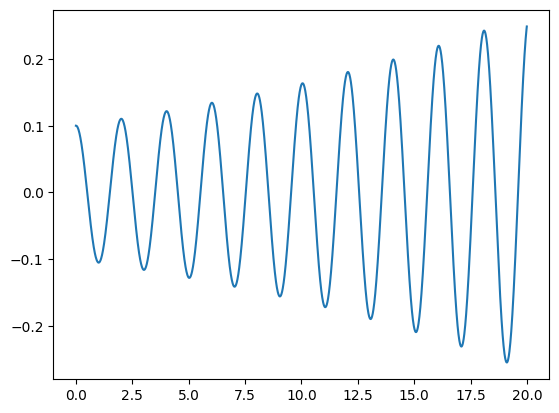

In [4]:
x0 = [0.1, 0.0]
hist, time = pendulum_forward_euler(pendulum_dynamics_wo_control, x0, 20, 0.01)
plt.plot(time, hist[:,0])

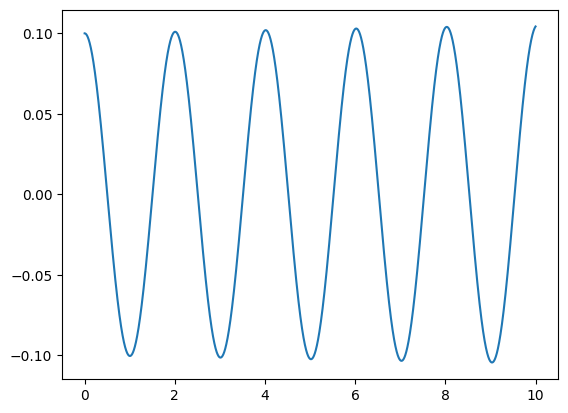

In [5]:
x0 = [0.1, 0.0]
hist, time = pendulum_forward_euler(pendulum_dynamics_wo_control, x0, 10, 0.001)
plt.plot(time, hist[:,0])

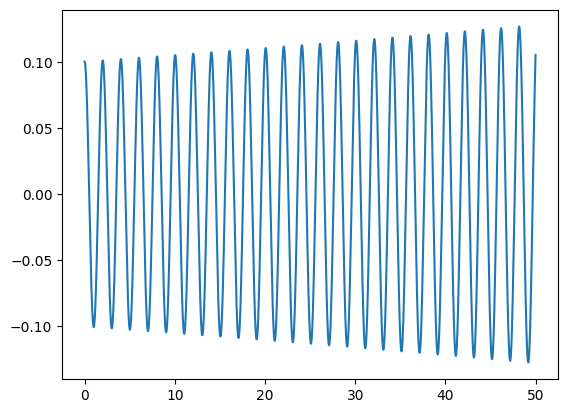

In [6]:
x0 = [0.1, 0.0]
hist, time = pendulum_forward_euler(pendulum_dynamics_wo_control, x0, 50, 0.001)
plt.plot(time, hist[:,0])

## EigenValue of Discretized State Space

In [7]:
def pendulum_euler_Ad(x0, h):
    θ = x0[0]
    g = 9.81
    l = 1
    
    Ad = np.array([
        [1, h],
        [-h*(g/l)*np.cos(θ), 1]
    ])
    
    return Ad

In [8]:
x0 = [0.1, 0.0]
Ad = pendulum_euler_Ad(x0, 0.001)
eigVal, eigVec = np.linalg.eig(Ad)
eigVal

array([1.+0.00312426j, 1.-0.00312426j])

## Distribution of Eigvals from 0 to 0.1

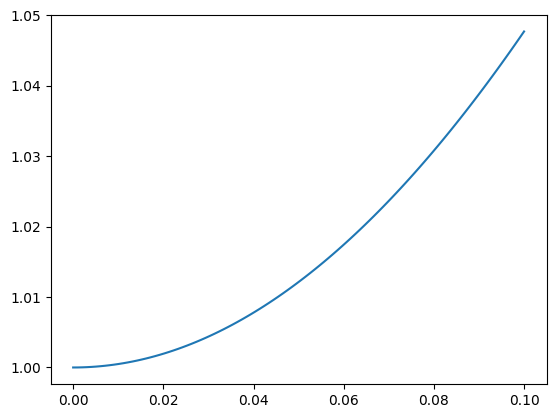

In [9]:
eignorms = np.zeros(100)
h = np.linspace(0, 0.1, 100)

x0 = [0.1, 0.0]

for i in range(0, len(eignorms)):
    eigVal, eigVec = np.linalg.eig(pendulum_euler_Ad(x0, h[i]))
    eignorms[i] = max(np.absolute(eigVal))

plt.plot(h, eignorms)

## Method 2. RK 4 - A Better Explicit Integrator

In [10]:
def pendulum_rk4(dynamics_func, x0, Tf, h):
    
    t = np.arange(0, Tf, h)

    x_hist = np.zeros((len(t), len(x0)))
    x_hist[0] = x0

    for i in range(1, len(t)):
        k1 = dynamics_func(x_hist[i-1])
        k2 = dynamics_func(x_hist[i-1] + h * 0.5 * k1)
        k3 = dynamics_func(x_hist[i-1] + h * 0.5 * k2)
        k4 = dynamics_func(x_hist[i-1] + h * k3)
        x_hist[i] = x_hist[i-1] + h/6.0 * (k1 + 2*k2 + 2*k3 + k4)
    
    return x_hist, t

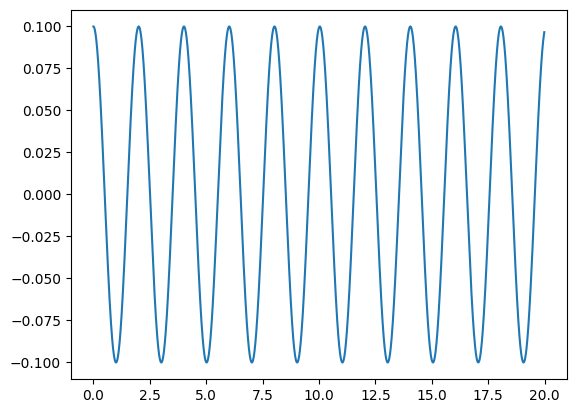

In [11]:
x0 = [0.1, 0.0]
hist, time = pendulum_rk4(pendulum_dynamics_wo_control, x0, 20, 0.01)
plt.plot(time, hist[:,0])

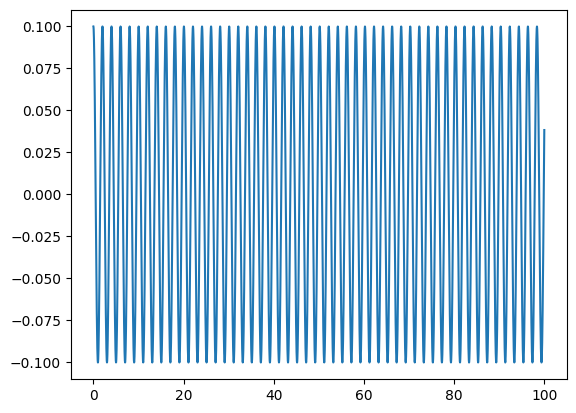

In [12]:
x0 = [0.1, 0.0]
hist, time = pendulum_rk4(pendulum_dynamics_wo_control, x0, 100, 0.01)
plt.plot(time, hist[:,0])

## Eigen Value of Discretized State Space

In [13]:
@jit
def _pendu_jit(x):

    g = 9.81
    l = 1
    
    q    = x[0]
    q_d  = x[1]
    q_dd = -g/l * jnp.sin(q)

    return jnp.array([q_d, q_dd])

@jit
def rk4(xk, h):
    
    k1 = _pendu_jit(xk)
    k2 = _pendu_jit(xk + h * 0.5 * k1)
    k3 = _pendu_jit(xk + h * 0.5 * k2)
    k4 = _pendu_jit(xk + h * k3)
    
    return xk + h/6.0 * (k1 + 2*k2 + 2*k3 + k4)

In [14]:
x0 = jnp.array([0.1, 0.0])
# a pair of (jacobian, auxiliary_data) is returned.
jacobian, auxiliary_data = jacrev(rk4, argnums=(0, 1))(x0, 0.1)

jacobian

Array([[ 0.9515882 ,  0.09837298],
       [-0.9603709 ,  0.95158046]], dtype=float32)

In [15]:
eigVal, eigVec = np.linalg.eig(np.array(jacobian))
np.absolute(eigVal)

array([0.9999936, 0.9999936], dtype=float32)

## Distribution of Eigvals from 0 to 1

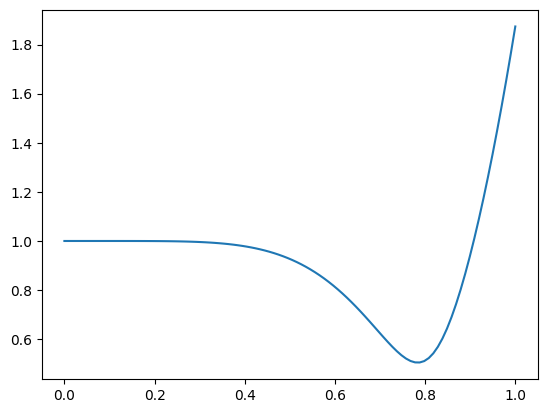

In [16]:
eignorms = np.zeros(100)
h = np.linspace(0, 1, 100)

x0 = jnp.array([0.1, 0.0])

for i in range(0, len(eignorms)):
    jacobian, auxiliary_data = jacrev(rk4, argnums=(0, 1))(x0, h[i])
    eigVal, eigVec = np.linalg.eig(np.array(jacobian))
    eignorms[i] = max(np.absolute(eigVal))

plt.plot(h, eignorms)

### There's downhill curve around h=0.8, that point will converge more faster

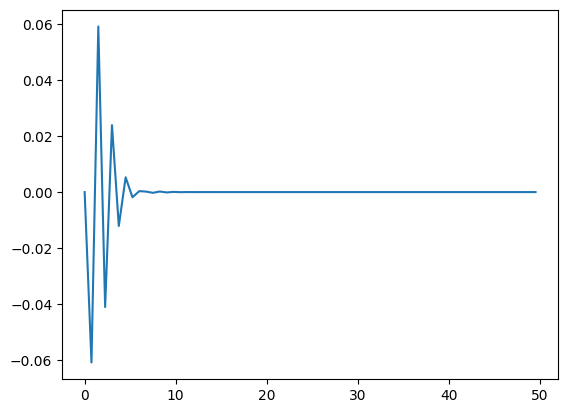

In [17]:
x0 = jnp.array([0.1, 0.0])

h = 0.75
hist, time = pendulum_rk4(pendulum_dynamics_wo_control, x0, 50, h)
plt.plot(time, hist[:,1])

## What about point around 1.0?

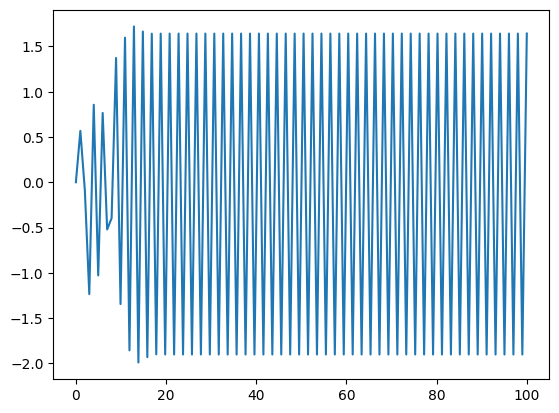

In [18]:
x0 = jnp.array([0.1, 0.0])

h = 0.99
hist, time = pendulum_rk4(pendulum_dynamics_wo_control, x0, 100, h)
plt.plot(time, hist[:,1])

## Method 3. Backward Euler Integration - Implicit Method

In [25]:
def pendulum_backward_euler(dynamics_func, x0, Tf, h):

    t = np.arange(0, Tf, h)
    
    x_hist = np.zeros((len(t), len(x0)))
    x_hist[0] = x0

    for i in range(0, len(t)-1):

        e = 1.0
        x_hist[i+1] = x_hist[i]

        while e > 1e-8:
            xn = x_hist[i] + h * dynamics_func(x_hist[i+1])
            e = np.linalg.norm(xn - x_hist[i+1])
            x_hist[i+1] = xn
            
    return x_hist, t

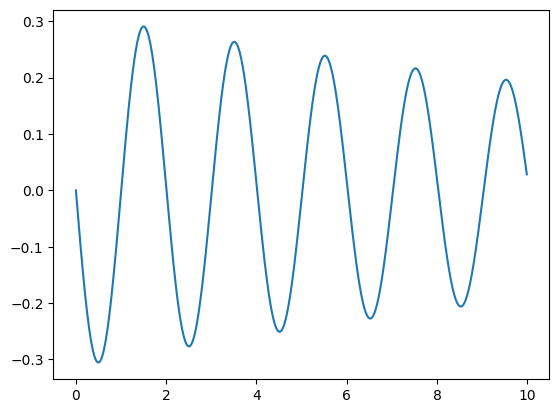

In [26]:
x0 = [0.1, 0.0]

hist, time = pendulum_backward_euler(pendulum_dynamics_wo_control, x0, 10, 0.01)
plt.plot(time, hist[:,1])

## Backward Euler Integration is always stable (in terms of convergence)

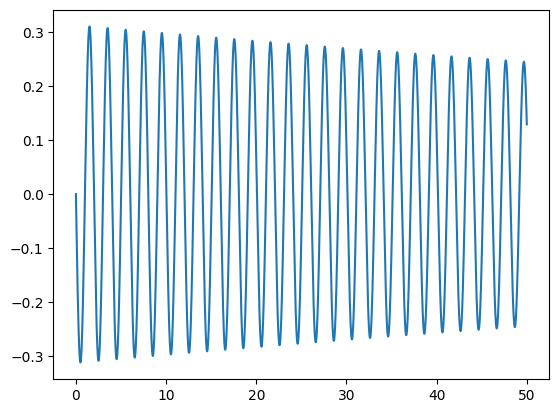

In [27]:
x0 = [0.1, 0.0]

hist, time = pendulum_backward_euler(pendulum_dynamics_wo_control, x0, 50, 0.001)
plt.plot(time, hist[:,1])

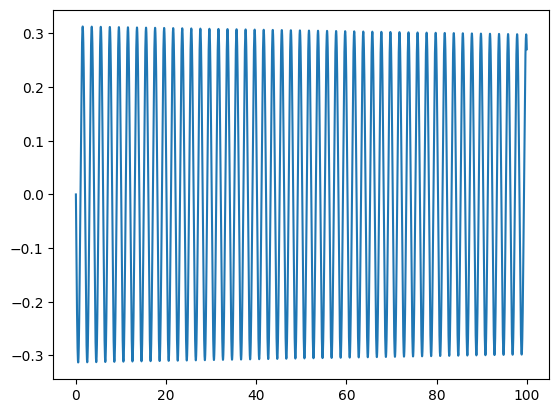

In [28]:
x0 = [0.1, 0.0]

hist, time = pendulum_backward_euler(pendulum_dynamics_wo_control, x0, 100, 0.0001)
plt.plot(time, hist[:,1])